In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# data.head()

In [6]:
X = data['comment_text']
y = data['target']

In [7]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [8]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [9]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Tokenizacija I vektorizacija teksta

In [10]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [11]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [12]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [39]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [14]:
X_train.shape, X_test.shape, X_validation.shape

((119770, 100), (73740, 100), (29943, 100))

In [40]:
X_train_validation = to_sequence(X_train_validation, max_len, tokenizer)

Kreira se matrica ugnjezdavanja

In [15]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Selekcija i evaluacija modela

In [ ]:
# Posto su klasa nebalansirane, potrebno je dodeliti im tezine
# tako da se vise kaznjava pogresna klasifikacija manjinske klase

weights = get_weights(y_train)
# TODO da li ovde treba train and validation

# tezinu za klasu 1 podesavamo rucno jer se ispostavlja da
# bolje klasifikuje TP instance ako nije bas tacna proporcija
weights[1] = 3.5
weights

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i keras wrapper 

In [55]:
# recnik parametara koje prima funkcija za kreiranje modela
params = {'num_of_classes' : [2],
          'num_of_features' : [20000],
          'embedding_dim' : [100],
          'kernel_size' : [3, 5, 7],
          'pool_size' : [3, 5],
          'filters' : [32, 64, 128],
          'dropout_rate' : [0.2, 0.3],
          'maxlen' : [50, 100, 200],
          'lr' : [0.00001, 0.0001, 0.001],
          'embedding_matrix' : [embedding_matrix]
          }
    

model_random = KerasClassifier(build_fn = create_model, epochs=10, batch_size=128, verbose=True)

randomized_cv = RandomizedSearchCV(estimator=model_random, param_distributions=params, cv=3, verbose=1, n_iter=2)

In [56]:
randomized_cv.fit(X_train_validation, y_train_validation, class_weight=weights)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 33, 64)            0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 33, 64)            28736     
_________________________________________________________________
max_pooling1d_91 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 11, 64)            0         
____________________________________________________________

max_pooling1d_97 (MaxPooling (None, 11, 32)            0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 11, 32)            0         
_________________________________________________________________
global_average_pooling1d_48  (None, 32)                0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 33        
Total params: 2,012,769
Trainable params: 12,769
Non-trainable params: 2,000,000
_________________________________________________________________
Epoch 1/10
780/780 [==============================] - 16s 20ms/step - loss: 0.5740 - accuracy: 0.7529
Epoch 2/10
780/780 [==============================] - 16s 20ms/step - loss: 0.5462 - accuracy: 0.8876
Epoch 3/10
780/780 [==============================] - 1

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001AF15EAF790>, as the constructor either does not set or modifies parameter embedding_matrix

In [54]:
randomized_cv.best_score_

0.9306273579597473

### 4. Formiranje modela

In [16]:
kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.3
embedding_dim = 100
lr = 0.0001

In [17]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                dropout_rate = dropout_rate, maxlen = max_len, lr = lr, embedding_matrix = embedding_matrix)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 64)             0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0

### 5. Obučavanje modela

In [19]:
epochs = 10
batch_size = 64

In [20]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/10
1872/1872 [==============================] - 23s 12ms/step - loss: 0.4029 - accuracy: 0.8425 - val_loss: 0.3296 - val_accuracy: 0.8835
Epoch 2/10
1872/1872 [==============================] - 25s 13ms/step - loss: 0.3053 - accuracy: 0.8900 - val_loss: 0.3102 - val_accuracy: 0.8916
Epoch 3/10
1872/1872 [==============================] - 32s 17ms/step - loss: 0.2774 - accuracy: 0.9017 - val_loss: 0.2420 - val_accuracy: 0.9180
Epoch 4/10
1872/1872 [==============================] - 29s 16ms/step - loss: 0.2626 - accuracy: 0.9088 - val_loss: 0.2715 - val_accuracy: 0.9067
Epoch 5/10
1872/1872 [==============================] - 29s 16ms/step - loss: 0.2524 - accuracy: 0.9116 - val_loss: 0.2704 - val_accuracy: 0.9075
Epoch 6/10
1872/1872 [==============================] - 29s 15ms/step - loss: 0.2447 - accuracy: 0.9150 - val_loss: 0.2309 - val_accuracy: 0.9212
Epoch 7/10
1872/1872 [==============================] - 28s 15ms/step - loss: 0.2375 - accuracy: 0.9177 - val_loss: 0.2656 -

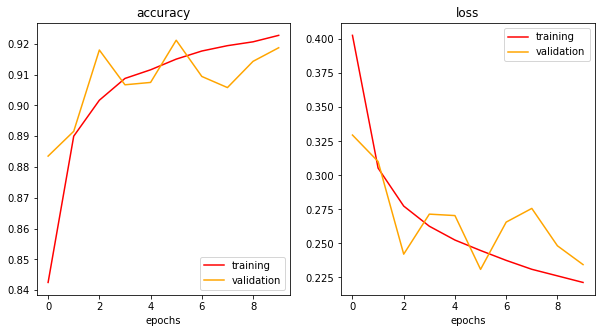

In [21]:
plot_graphs(binary_history, ['accuracy', 'loss'])

### 6. Evaluacija modela

In [22]:
scores = binary_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])

2305/2305 [==============================] - 7s 3ms/step - loss: 0.2350 - accuracy: 0.9189
Loss:  0.23495498299598694
Test accuracy:  0.9189313650131226


Predviđanje: 

In [23]:
y_predicted = binary_model.predict(X_test)

In [24]:
y_labels = [int(score > 0.5) for score in y_predicted]

In [25]:
# F1 mera je bolja metrika kada su neizbalansirane klase

print('F1: ', metrics.f1_score(y_test, y_labels))

F1:  0.6765151515151515


In [26]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[61511  4815]
 [ 1163  6251]]


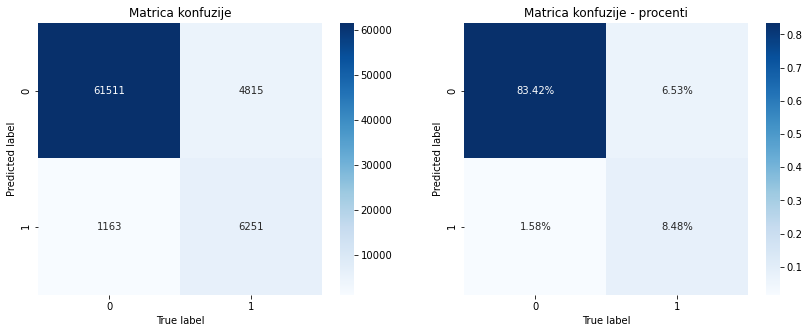

In [33]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary')

In [29]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     66326
           1       0.56      0.84      0.68      7414

    accuracy                           0.92     73740
   macro avg       0.77      0.89      0.82     73740
weighted avg       0.94      0.92      0.93     73740

